<a href="https://colab.research.google.com/github/viktor-mashalov/Tax-Free-RSU-Transition/blob/main/Tax_Free_RSU_Transition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODEL A: DIRECT-INDEXING TAX-LOSS-HARVEST SIMULATOR INTO SPY

We sell RSU lots that decline 8% below their cost basis to harvest losses, use those losses to offset gains when other RSU lots are sold at a profit, and then reinvest all sale proceeds into SPY.

RSU ticker symbol [MSFT]                      : 
Simulation start date  YYYY-MM-DD [2015-06-13]: 
Simulation end date    YYYY-MM-DD [2025-06-13]: 
Loss-harvest & conversion begin date [2021-01-01]: 

YF.download() has changed argument auto_adjust default to True

======================= VESTING LOG =======================
      date  shares  vest_price
2015-06-30     100       38.28
2015-09-30     100       38.63
2015-12-31     100       48.75
2016-03-31     100       48.88
2016-06-30     100       45.60
2016-09-30     100       51.65
2017-01-03     100       56.50
2017-03-31     100       59.82
2017-06-30     100       62.97
2017-10-02     100       68.52
2018-01-02     100       79.33
2018-04-02     100       82.08
2018-07-02     100       93.14
2018-10-01     100      108.08
2018-12-31     100       95.37
2019-04-01     100      112.23
2019-07-01     100      128.41
2019-09-30     100      132.02
2019-12-31     100      150.26
2020-03-31     100      150.68
2020-06-30     100      1

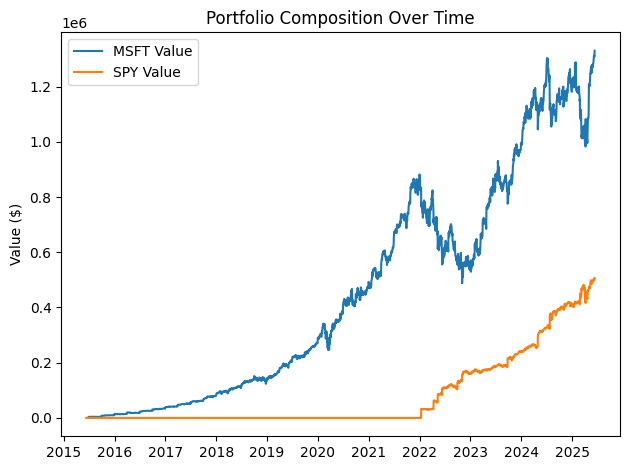

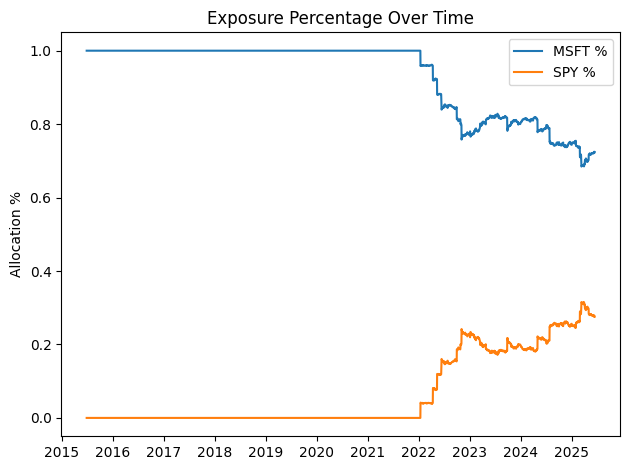

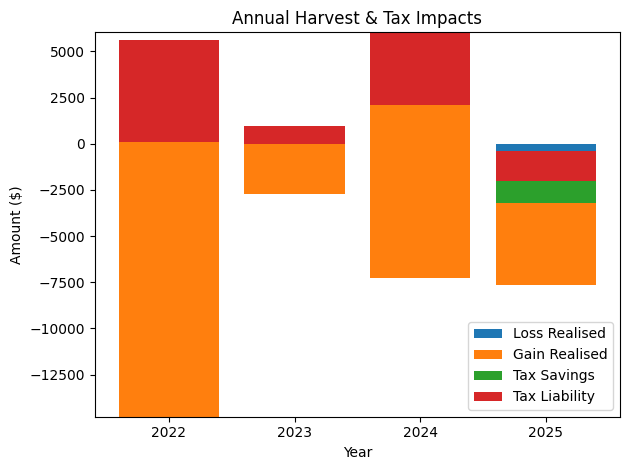

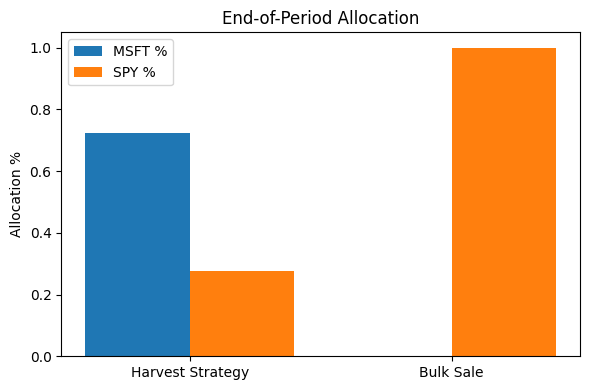

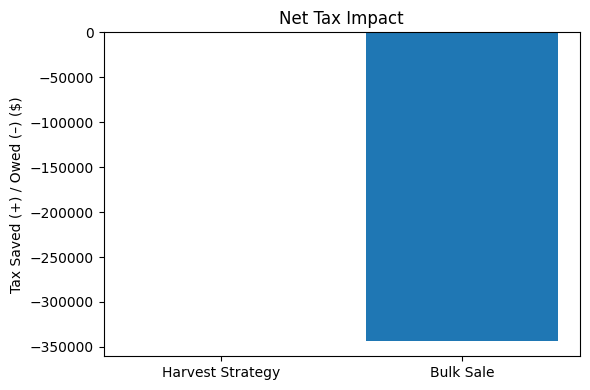

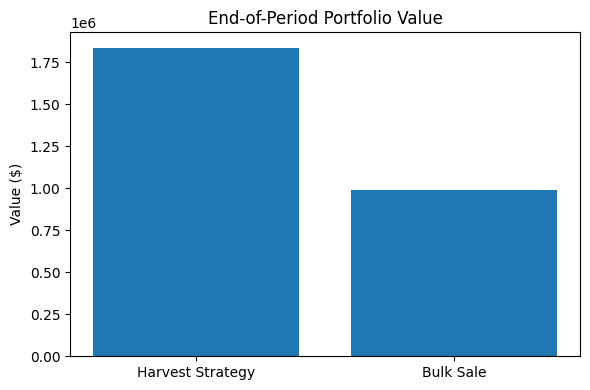

In [1]:
#!/usr/bin/env python3
"""
####################################################################################################
DIRECT-INDEXING TAX-LOSS-HARVEST SIMULATOR INTO SPY
Author   : Viktor Mashalov

PROFESSIONAL DISCLAIMER  –  NOT FINANCIAL ADVICE
----------------------------------------------------------------------------------------------------
This script is provided strictly for educational and illustrative purposes.  Nothing herein
constitutes or should be construed as personalized investment advice, a solicitation, or a
recommendation to buy, sell, or hold any security or implement any strategy.  Past performance is
not indicative of future results.  Use entirely at your own risk.  Consult your own qualified
financial, tax, and legal advisers before acting on any information contained in or generated by
this program.  The author and all affiliated parties expressly disclaim any liability for losses,
damages, or costs of any kind arising out of the use of this material.
####################################################################################################
"""
# ----------------------------------------- IMPORTS ------------------------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------- INTERACTIVE USER PARAMETERS -------------------------------------
ticker_rsu = input("RSU ticker symbol [MSFT]                      : ").strip().upper() or "MSFT"
start_date = input("Simulation start date  YYYY-MM-DD [2015-06-13]: ").strip() or "2015-06-13"
end_date   = input("Simulation end date    YYYY-MM-DD [2025-06-13]: ").strip() or "2025-06-13"
transition_start_date = (
    input("Loss-harvest & conversion begin date [2021-01-01]: ").strip()
    or "2021-01-01"
)

# --------------------------- STATIC PARAMETERS (EDIT IF DESIRED) ---------------------------------
benchmark_etf    = "SPY"      # ETF into which RSU proceeds are rolled
vest_freq        = "QE-DEC"   # Quarterly vest schedule (Mar/Jun/Sep/Dec)
shares_per_vest  = 100        # Shares that vest each quarter
harvest_loss_pct = 0.08       # Trigger: % below basis to harvest
assumed_tax_rate = 0.37       # Marginal tax rate for gains & losses

# ------------------------------- FETCH PRICE DATA -------------------------------------------------
print(f"\nDownloading price history for {ticker_rsu} and {benchmark_etf} …")
price_rsu = yf.download(ticker_rsu, start=start_date, end=end_date, progress=False)["Close"]
price_etf = yf.download(benchmark_etf, start=start_date, end=end_date, progress=False)["Close"]

df = pd.concat([price_rsu, price_etf], axis=1).dropna()
df.columns = ["rsu", "etf"]

# ----------------------------- BUILD VESTING CALENDAR ---------------------------------------------
vest_anchor = pd.date_range(start=df.index.min(), end=df.index.max(), freq=vest_freq)
vest_dates  = [df.index[pos] for pos in df.index.searchsorted(vest_anchor) if pos < len(df.index)]

# ------------------------------- INITIALISE STATE -------------------------------------------------
transition_start = pd.to_datetime(transition_start_date)

rsu_lots   = []   # open RSU lots
vest_log   = []   # details of each vest event
trade_log  = []   # both loss- and gain-sale events
daily_snap = []   # daily portfolio valuation snapshots

# ------------------------------------- MAIN LOOP --------------------------------------------------
for today, prices in df.iterrows():
    rsu_px, etf_px = prices["rsu"], prices["etf"]

    # (a) Vesting
    if today in vest_dates:
        rsu_lots.append({"shares": shares_per_vest, "basis": rsu_px})
        vest_log.append({"date": today, "shares": shares_per_vest, "vest_price": rsu_px})

    # (b) Harvesting after transition start
    if today >= transition_start:
        # (b.1) Loss-harvest → sell RSU at a loss & buy ETF
        for lot in rsu_lots.copy():
            if rsu_px < lot["basis"] * (1 - harvest_loss_pct):
                shares       = lot["shares"]
                basis        = lot["basis"]
                proceeds     = shares * rsu_px
                loss_amount  = shares * (rsu_px - basis)  # negative
                tax_savings  = -loss_amount * assumed_tax_rate

                rsu_lots.remove(lot)
                trade_log.append({
                    "date": today,
                    "shares_sold": shares,
                    "basis": basis,
                    "sale_price": rsu_px,
                    "loss": loss_amount,
                    "gain": 0.0,
                    "tax_savings": tax_savings,
                    "tax_liability": 0.0,
                    "etf_shares_bought": proceeds / etf_px
                })

        # (b.2) Gain-harvest to offset losses → sell RSU at a gain & buy ETF
        cum_loss = sum(t["loss"] for t in trade_log)
        cum_gain = sum(t["gain"] for t in trade_log)
        needed_gain = abs(cum_loss) - cum_gain

        if needed_gain > 0:
            for lot in rsu_lots.copy():
                if cum_gain >= abs(cum_loss):
                    break
                if rsu_px > lot["basis"]:
                    shares          = lot["shares"]
                    basis           = lot["basis"]
                    per_share_gain  = rsu_px - basis
                    max_gain        = shares * per_share_gain
                    sell_shares     = min(shares, int(np.ceil(needed_gain / per_share_gain)))
                    gain_amount     = sell_shares * per_share_gain
                    proceeds        = sell_shares * rsu_px
                    tax_liability   = gain_amount * assumed_tax_rate

                    # remove or reduce the lot
                    if sell_shares == shares:
                        rsu_lots.remove(lot)
                    else:
                        lot["shares"] -= sell_shares

                    cum_gain += gain_amount
                    trade_log.append({
                        "date": today,
                        "shares_sold": sell_shares,
                        "basis": basis,
                        "sale_price": rsu_px,
                        "loss": 0.0,
                        "gain": gain_amount,
                        "tax_savings": 0.0,
                        "tax_liability": tax_liability,
                        "etf_shares_bought": proceeds / etf_px
                    })

    # (c) Accumulated ETF shares
    total_etf_shares = sum(t["etf_shares_bought"] for t in trade_log)

    # (d) Daily snapshot
    total_rsu_shares = sum(l["shares"] for l in rsu_lots)
    val_rsu          = total_rsu_shares * rsu_px
    val_etf          = total_etf_shares  * etf_px
    total_val        = val_rsu + val_etf

    daily_snap.append({
        "date": today,
        f"{ticker_rsu}_Shares": total_rsu_shares,
        f"{benchmark_etf}_Shares": total_etf_shares,
        f"{ticker_rsu}_Value": val_rsu,
        f"{benchmark_etf}_Value": val_etf,
        "Total_Value": total_val,
        "Cumulative_Loss": sum(t["loss"] for t in trade_log),
        "Cumulative_Gain": sum(t["gain"] for t in trade_log),
        "Estimated_Tax_Savings": sum(t["tax_savings"] for t in trade_log),
        "Estimated_Tax_Liability": sum(t["tax_liability"] for t in trade_log)
    })

# --------------------------- CONVERT LOGS TO DATAFRAMES -------------------------------------------
results_df = pd.DataFrame(daily_snap).set_index("date")
vest_df    = pd.DataFrame(vest_log).assign(year=lambda x: x["date"].dt.year)
trades_df  = pd.DataFrame(trade_log)
if not trades_df.empty:
    trades_df["year"] = trades_df["date"].dt.year

# -------------------------- FINAL SNAPSHOT & COMPARISONS ------------------------------------------
final_date        = results_df.index[-1]
rsu_px_end        = df.loc[final_date, "rsu"]
etf_px_end        = df.loc[final_date, "etf"]
final_rec         = results_df.iloc[-1]

final_port_value  = final_rec["Total_Value"]
strat_rsu_pct     = final_rec[f"{ticker_rsu}_Value"] / final_port_value
strat_etf_pct     = final_rec[f"{benchmark_etf}_Value"] / final_port_value

net_tax_savings   = final_rec["Estimated_Tax_Savings"]
net_tax_liability = final_rec["Estimated_Tax_Liability"]
net_tax_impact    = net_tax_savings - net_tax_liability

# ------------------------------ PRINT TEXT OUTPUT -------------------------------------------------
pd.set_option("display.float_format", "{:,.2f}".format)

print("\n======================= VESTING LOG =======================")
print(vest_df[["date", "shares", "vest_price"]].to_string(index=False))

print("\n================== VESTED SHARES BY YEAR ==================")
print(vest_df.groupby("year")
      .agg(total_vested_shares=("shares","sum"),
           avg_vest_price=("vest_price","mean"))
      .to_string())

if not trades_df.empty:
    print("\n==================== TRADE LOG ==========================")
    print(trades_df[[
        "date","shares_sold","basis","sale_price",
        "loss","gain","tax_savings","tax_liability","etf_shares_bought"
    ]].to_string(index=False))

    print("\n============= ANNUAL REALISED LOSS & GAIN ===============")
    print(trades_df.groupby("year")
          .agg(loss_realised=("loss","sum"),
               gain_realised=("gain","sum"))
          .to_string())

    print("\n============= ANNUAL TAX SAVINGS & LIABILITY ============")
    print(trades_df.groupby("year")
          .agg(tax_savings=("tax_savings","sum"),
               tax_liability=("tax_liability","sum"))
          .to_string())

print(f"\n================= END-OF-PERIOD (as of {final_date.date()}) ================")
print("Enhanced Tax-Harvest with Gain-Offset & Reinvestment")
print(f"  • Portfolio Value    : ${final_port_value:,.2f}")
print(f"  • {ticker_rsu} Allocation : {strat_rsu_pct:.1%}")
print(f"  • {benchmark_etf} Allocation : {strat_etf_pct:.1%}")
print(f"  • Net Tax Impact     : ${net_tax_impact:,.2f}  (≈ 0 if perfectly offset)\n")

# --------------------------------------- PLOTTING -------------------------------------------------
plt.style.use("default")

# (1) Portfolio Value Over Time
fig, ax = plt.subplots()
ax.plot(results_df.index, results_df[f"{ticker_rsu}_Value"], label=f"{ticker_rsu} Value")
ax.plot(results_df.index, results_df[f"{benchmark_etf}_Value"], label=f"{benchmark_etf} Value")
ax.set_title("Portfolio Composition Over Time")
ax.set_ylabel("Value ($)")
ax.legend()
plt.tight_layout()
plt.show()

# (2) Allocation % Over Time
fig2, ax2 = plt.subplots()
ax2.plot(results_df.index, results_df[f"{ticker_rsu}_Value"] / results_df["Total_Value"], label=f"{ticker_rsu} %")
ax2.plot(results_df.index, results_df[f"{benchmark_etf}_Value"] / results_df["Total_Value"], label=f"{benchmark_etf} %")
ax2.set_title("Exposure Percentage Over Time")
ax2.set_ylabel("Allocation %")
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Annual Loss & Gain Harvested with Tax Impact
if not trades_df.empty:
    yearly = trades_df.groupby("year").agg(loss=("loss","sum"),
                                          gain=("gain","sum"),
                                          tax_savings=("tax_savings","sum"),
                                          tax_liability=("tax_liability","sum"))
    fig3, ax3 = plt.subplots()
    ax3.bar(yearly.index.astype(str), yearly["loss"], label="Loss Realised")
    ax3.bar(yearly.index.astype(str), yearly["gain"], bottom=yearly["loss"], label="Gain Realised")
    ax3.bar(yearly.index.astype(str), yearly["tax_savings"], bottom=yearly["loss"]+yearly["gain"], label="Tax Savings")
    ax3.bar(yearly.index.astype(str), -yearly["tax_liability"], bottom=yearly["loss"]+yearly["gain"]+yearly["tax_savings"], label="Tax Liability")
    ax3.set_title("Annual Harvest & Tax Impacts")
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Amount ($)")
    ax3.legend()
    plt.tight_layout()
    plt.show()

# (4) End-of-Period Allocation Comparison
fig4, ax4 = plt.subplots(figsize=(6,4))
x, width = np.arange(2), 0.4
ax4.bar(x - width/2, [strat_rsu_pct, 0], width, label=f"{ticker_rsu} %")
ax4.bar(x + width/2, [strat_etf_pct, 1.0], width, label=f"{benchmark_etf} %")
ax4.set_xticks(x)
ax4.set_xticklabels(["Harvest Strategy", "Bulk Sale"])
ax4.set_title("End-of-Period Allocation")
ax4.set_ylabel("Allocation %")
ax4.legend()
plt.tight_layout()
plt.show()

# (5) Net Tax Impact Comparison
fig5, ax5 = plt.subplots(figsize=(6,4))
labels = ["Harvest Strategy", "Bulk Sale"]
impact = [net_tax_savings - net_tax_liability, - (sum(l["shares"] * max(0, rsu_px_end - l["basis"]) for l in rsu_lots) * assumed_tax_rate)]
ax5.bar(labels, impact)
ax5.set_title("Net Tax Impact")
ax5.set_ylabel("Tax Saved (+) / Owed (–) ($)")
plt.tight_layout()
plt.show()

# (6) Portfolio Value Comparison
bulk_value = (sum(l["shares"] for l in rsu_lots) * rsu_px_end - sum(l["shares"] * max(0, rsu_px_end - l["basis"]) for l in rsu_lots) * assumed_tax_rate)  # net proceeds reinvested
fig6, ax6 = plt.subplots(figsize=(6,4))
ax6.bar(["Harvest Strategy", "Bulk Sale"], [final_port_value, bulk_value])
ax6.set_title("End-of-Period Portfolio Value")
ax6.set_ylabel("Value ($)")
plt.tight_layout()
plt.show()

#MODEL B: DIRECT-INDEXING TAX-LOSS-HARVEST SIMULATOR WITH SECTOR ETF PORTFOLIO



We systematically sell RSU lots once they fall 8% below cost, realizing capital losses that immediately offset gains when we later sell in-the-money RSU lots.  All sale proceeds are reinvested into an equally weighted basket of sector ETFs.  Whenever any ETF in that basket also drops 8% below its purchase basis, we harvest those losses and use them to offset additional RSU gains—then invest the proceeds back into the same ETF portfolio.  By repeating this loop of loss-harvesting (from both the concentrated RSUs and the diversified ETFs) and gain-offsetting, we migrate our exposure from the original RSU position into the sector ETF portfolio without ever triggering a net tax liability.


RSU ticker symbol [MSFT]                      : 
Simulation start date  YYYY-MM-DD [2015-06-13]: 
Simulation end date    YYYY-MM-DD [2025-06-13]: 
Loss-harvest & conversion begin date [2021-01-01]: 


======================= VESTING LOG =======================
      date  shares  vest_price
2018-07-02     100       93.14
2018-10-01     100      108.08
2018-12-31     100       95.37
2019-04-01     100      112.23
2019-07-01     100      128.41
2019-09-30     100      132.02
2019-12-31     100      150.26
2020-03-31     100      150.68
2020-06-30     100      194.98
2020-09-30     100      202.00
2020-12-31     100      214.17
2021-03-31     100      227.55
2021-06-30     100      262.06
2021-09-30     100      273.24
2021-12-31     100      326.56
2022-03-31     100      299.98
2022-06-30     100      250.48
2022-09-30     100      227.62
2023-01-03     100      234.81
2023-03-31     100      283.27
2023-06-30     100      335.33
2023-10-02     100      317.54
2024-01-02     100      36

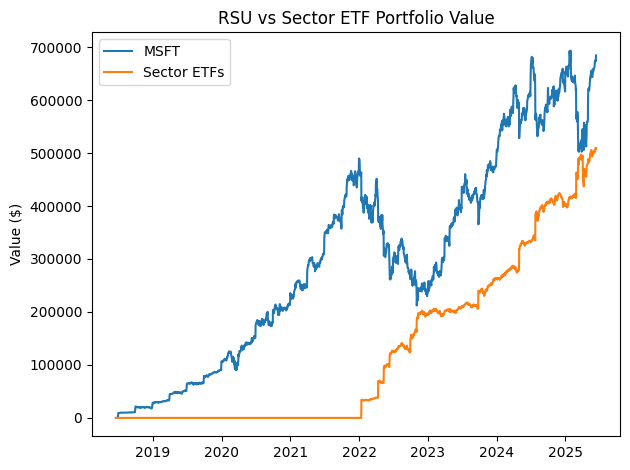

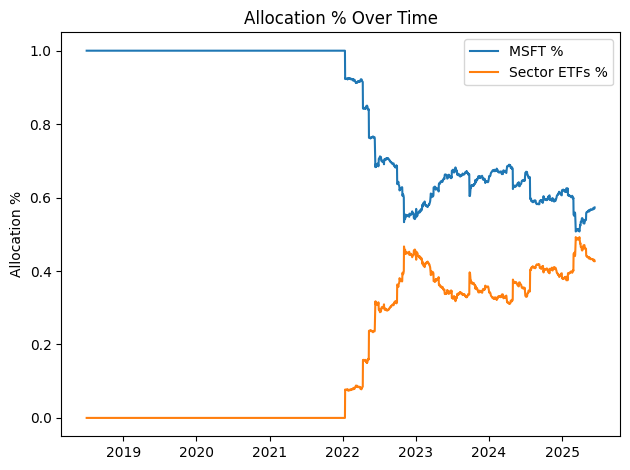

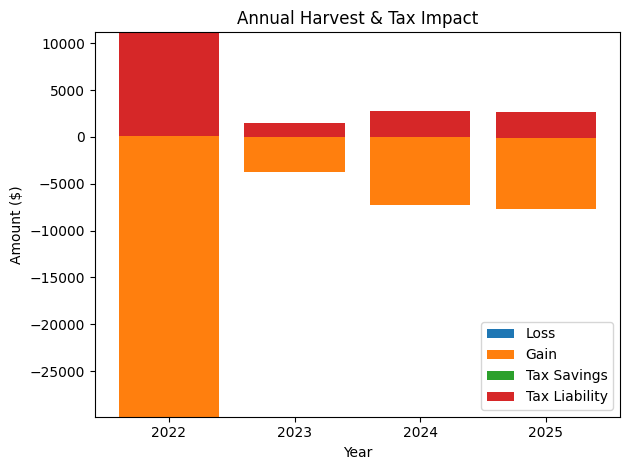

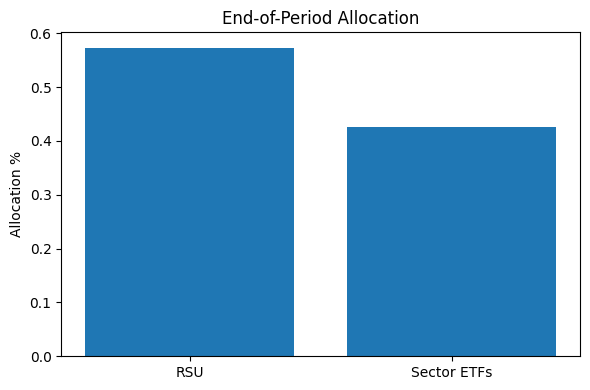

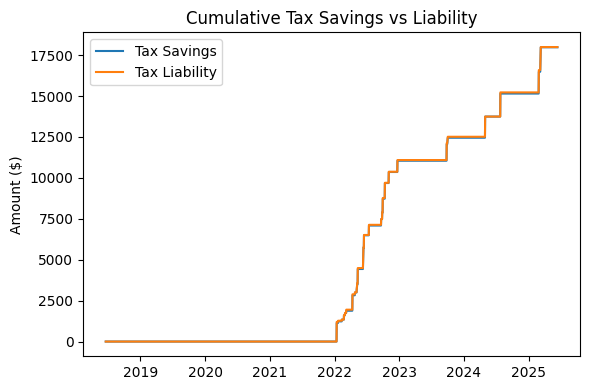

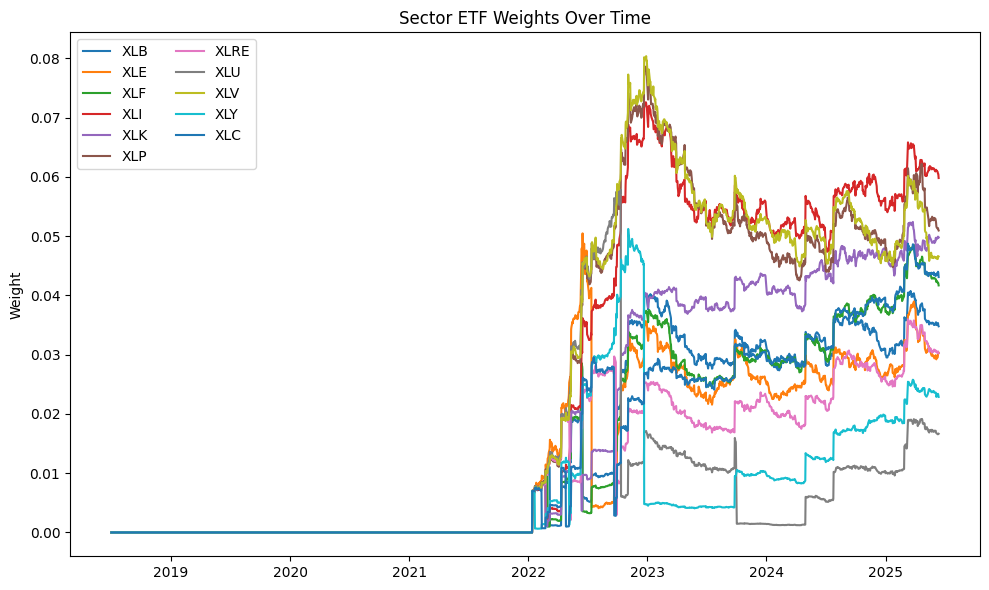

In [4]:
#!/usr/bin/env python3

"""
####################################################################################################
DIRECT-INDEXING TAX-LOSS-HARVEST SIMULATOR WITH SECTOR ETF PORTFOLIO (VECTORIZED, FIXED PLOTTING)
Author   : Viktor Mashalov

PROFESSIONAL DISCLAIMER  –  NOT FINANCIAL ADVICE
----------------------------------------------------------------------------------------------------
This script is provided strictly for educational and illustrative purposes.  Nothing herein
constitutes or should be construed as personalized investment advice, a solicitation, or a
recommendation to buy, sell, or hold any security or implement any strategy.  Past performance is
not indicative of future results.  Use entirely at your own risk.  Consult your own qualified
financial, tax, and legal advisers before acting on any information contained in or generated by
this program.  The author and all affiliated parties expressly disclaim any liability for losses,
damages, or costs of any kind arising out of the use of this material.
####################################################################################################
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------- USER PARAMETERS -------------------------------------
ticker_rsu = input("RSU ticker symbol [MSFT]                      : ").strip().upper() or "MSFT"
start_date = input("Simulation start date  YYYY-MM-DD [2015-06-13]: ").strip() or "2015-06-13"
end_date   = input("Simulation end date    YYYY-MM-DD [2025-06-13]: ").strip() or "2025-06-13"
transition_start_date = (
    input("Loss-harvest & conversion begin date [2021-01-01]: ").strip()
    or "2021-01-01"
)

sector_etfs      = ['XLB','XLE','XLF','XLI','XLK','XLP','XLRE','XLU','XLV','XLY','XLC']
n_sectors        = len(sector_etfs)
vest_freq        = "QE-DEC"    # Quarterly vest schedule
shares_per_vest  = 100         # Shares that vest each quarter
harvest_loss_pct = 0.08        # 8% drop triggers loss-harvest
assumed_tax_rate = 0.37        # Marginal tax rate

# ------------------------------- FETCH PRICE DATA -------------------------------------------------
symbols = [ticker_rsu] + sector_etfs
print(f"\nDownloading price history for {symbols} …")
price_data = (
    yf.download(symbols, start=start_date, end=end_date, progress=False)
      ["Close"]
      .dropna()
)

# ----------------------------- BUILD VESTING CALENDAR ---------------------------------------------
vest_anchor = pd.date_range(
    start=price_data.index.min(),
    end=price_data.index.max(),
    freq=vest_freq
)
vest_dates = [
    price_data.index[pos]
    for pos in price_data.index.searchsorted(vest_anchor)
    if pos < len(price_data.index)
]
transition_start = pd.to_datetime(transition_start_date)

# ------------------------------- INITIALISE STATE -------------------------------------------------
rsu_df     = pd.DataFrame(columns=["shares","basis"])
etf_pos    = pd.DataFrame(0.0, index=sector_etfs, columns=["shares","basis"])
vest_log   = []
trade_log  = []
daily_snap = []

# ------------------------------------- MAIN LOOP --------------------------------------------------
for today, row in price_data.iterrows():
    px_rsu = row[ticker_rsu]
    px_etf = row[sector_etfs]

    # (a) Vesting
    if today in vest_dates:
        rsu_df.loc[len(rsu_df)] = [shares_per_vest, px_rsu]
        vest_log.append({"date": today, "shares": shares_per_vest, "vest_price": px_rsu})

    # (b) Harvesting after transition start
    if today >= transition_start:
        # (b.1) RSU loss-harvest
        mask = px_rsu < rsu_df["basis"] * (1 - harvest_loss_pct)
        if mask.any():
            sold     = rsu_df[mask].copy()
            proceeds = (sold["shares"] * px_rsu).sum()
            loss_amt = (sold["shares"] * (px_rsu - sold["basis"])).sum()
            tax_sav  = -loss_amt * assumed_tax_rate
            rsu_df   = rsu_df[~mask].reset_index(drop=True)

            buy_counts = {}
            for sym in sector_etfs:
                cnt = (proceeds / n_sectors) / px_etf[sym]
                old_sh, old_b = etf_pos.at[sym,"shares"], etf_pos.at[sym,"basis"]
                new_sh = old_sh + cnt
                new_b  = ((old_sh * old_b) + (cnt * px_etf[sym])) / new_sh if new_sh > 0 else px_etf[sym]
                etf_pos.at[sym,"shares"] = new_sh
                etf_pos.at[sym,"basis"]  = new_b
                buy_counts[sym] = cnt

            trade_log.append({
                "date": today,
                "ticker_sold": ticker_rsu,
                "type": "loss",
                "shares_sold": sold["shares"].sum(),
                "price": px_rsu,
                "loss": loss_amt,
                "gain": 0.0,
                "tax_savings": tax_sav,
                "tax_liability": 0.0,
                "etf_buys": buy_counts
            })

        # (b.2) ETF loss-harvest
        for sym in sector_etfs:
            threshold = etf_pos.at[sym,"basis"] * (1 - harvest_loss_pct)
            if px_etf[sym] < threshold and etf_pos.at[sym,"shares"] > 0:
                s        = etf_pos.at[sym,"shares"]
                b        = etf_pos.at[sym,"basis"]
                proceeds = s * px_etf[sym]
                loss_amt = s * (px_etf[sym] - b)
                tax_sav  = -loss_amt * assumed_tax_rate
                etf_pos.at[sym,"shares"] = 0.0
                etf_pos.at[sym,"basis"]  = 0.0

                buy_counts = {}
                for s2 in sector_etfs:
                    cnt = (proceeds / n_sectors) / px_etf[s2]
                    old_sh, old_b = etf_pos.at[s2,"shares"], etf_pos.at[s2,"basis"]
                    new_sh = old_sh + cnt
                    new_b  = ((old_sh * old_b) + (cnt * px_etf[s2])) / new_sh if new_sh > 0 else px_etf[s2]
                    etf_pos.at[s2,"shares"] = new_sh
                    etf_pos.at[s2,"basis"]  = new_b
                    buy_counts[s2] = cnt

                trade_log.append({
                    "date": today,
                    "ticker_sold": sym,
                    "type": "loss",
                    "shares_sold": s,
                    "price": px_etf[sym],
                    "loss": loss_amt,
                    "gain": 0.0,
                    "tax_savings": tax_sav,
                    "tax_liability": 0.0,
                    "etf_buys": buy_counts
                })

        # (b.3) RSU gain-harvest to offset losses
        cum_loss = sum(t["loss"] for t in trade_log)
        cum_gain = sum(t["gain"] for t in trade_log)
        needed   = abs(cum_loss) - cum_gain
        if needed > 0 and not rsu_df.empty:
            temp          = rsu_df.sort_values("basis").reset_index()
            gain_realized = 0.0
            remove_idxs   = []
            for _, lot in temp.iterrows():
                if gain_realized >= needed:
                    break
                if px_rsu > lot["basis"]:
                    max_gain    = (px_rsu - lot["basis"]) * lot["shares"]
                    sell_shares = lot["shares"]
                    if gain_realized + max_gain > needed:
                        sell_shares = int(np.ceil((needed - gain_realized) / (px_rsu - lot["basis"])))
                    gain_amt = sell_shares * (px_rsu - lot["basis"])
                    proceeds = sell_shares * px_rsu
                    tax_liab = gain_amt * assumed_tax_rate

                    if sell_shares == lot["shares"]:
                        remove_idxs.append(lot["index"])
                    else:
                        rsu_df.loc[lot["index"],"shares"] -= sell_shares

                    gain_realized += gain_amt

                    buy_counts = {}
                    for sym in sector_etfs:
                        cnt = (proceeds / n_sectors) / px_etf[sym]
                        old_sh, old_b = etf_pos.at[sym,"shares"], etf_pos.at[sym,"basis"]
                        new_sh = old_sh + cnt
                        new_b  = ((old_sh * old_b) + (cnt * px_etf[sym])) / new_sh if new_sh > 0 else px_etf[sym]
                        etf_pos.at[sym,"shares"] = new_sh
                        etf_pos.at[sym,"basis"]  = new_b
                        buy_counts[sym] = cnt

                    trade_log.append({
                        "date": today,
                        "ticker_sold": ticker_rsu,
                        "type": "gain",
                        "shares_sold": sell_shares,
                        "price": px_rsu,
                        "loss": 0.0,
                        "gain": gain_amt,
                        "tax_savings": 0.0,
                        "tax_liability": tax_liab,
                        "etf_buys": buy_counts
                    })

            rsu_df = rsu_df.drop(index=remove_idxs).reset_index(drop=True)

    # (c) DAILY SNAPSHOT
    cum_loss = sum(t["loss"] for t in trade_log)
    cum_gain = sum(t["gain"] for t in trade_log)

    rsu_shares = rsu_df["shares"].sum()
    rsu_value  = rsu_shares * px_rsu
    etf_values = {sym: etf_pos.at[sym,"shares"] * px_etf[sym] for sym in sector_etfs}
    total_val  = rsu_value + sum(etf_values.values())

    snap = {
        "date": today,
        f"{ticker_rsu}_shares": rsu_shares,
        f"{ticker_rsu}_value": rsu_value,
        "Total_Value": total_val,
        "Cumulative_Loss": cum_loss,
        "Cumulative_Gain": cum_gain,
        "Tax_Savings": sum(t["tax_savings"] for t in trade_log),
        "Tax_Liability": sum(t["tax_liability"] for t in trade_log)
    }
    for sym in sector_etfs:
        snap[f"{sym}_shares"] = etf_pos.at[sym,"shares"]
        snap[f"{sym}_value"]  = etf_values[sym]

    daily_snap.append(snap)

# --------------------------- RESULTS & PLOTTING -------------------------------------------

results_df = pd.DataFrame(daily_snap).set_index("date")
vest_df    = pd.DataFrame(vest_log).assign(year=lambda x: x["date"].dt.year)
trades_df  = pd.DataFrame(trade_log)
if not trades_df.empty:
    trades_df["year"] = trades_df["date"].dt.year

final      = results_df.iloc[-1]
final_date = results_df.index[-1]

# compute for plots
pct_rsu = final[f"{ticker_rsu}_value"] / final["Total_Value"]
pct_etf = 1.0 - pct_rsu
net_tax = final["Tax_Savings"] - final["Tax_Liability"]

# -- Text summary --
print("\n======================= VESTING LOG =======================")
print(vest_df[["date","shares","vest_price"]].to_string(index=False))

print("\n================== VESTED SHARES BY YEAR ==================")
print(vest_df.groupby("year")
      .agg(total_vested=("shares","sum"),
           avg_price=("vest_price","mean"))
      .to_string())

if not trades_df.empty:
    print("\n==================== TRADE LOG ==========================")
    print(trades_df[[
        "date","ticker_sold","type","shares_sold","price",
        "loss","gain","tax_savings","tax_liability"
    ]].to_string(index=False))

    print("\n============= ANNUAL LOSS & GAIN HARVEST ===============")
    print(trades_df.groupby("year")
          .agg(loss_realised=("loss","sum"),
               gain_realised=("gain","sum"))
          .to_string())

    print("\n=========== ANNUAL TAX SAVINGS & LIABILITY ============")
    print(trades_df.groupby("year")
          .agg(tax_savings=("tax_savings","sum"),
               tax_liability=("tax_liability","sum"))
          .to_string())

print(f"\n================= END-OF-PERIOD (as of {final_date.date()}) ================")
print("Sector ETF Tax-Harvest & RSU Gain-Offset Strategy")
print(f"  • Portfolio Value    : ${final['Total_Value']:,.2f}")
print(f"  • {ticker_rsu} Value     : ${final[f'{ticker_rsu}_value']:,.2f}")
print(f"  • ETFs Value         : ${final['Total_Value'] - final[f'{ticker_rsu}_value']:,.2f}")
print(f"  • Net Tax Impact     : ${net_tax:,.2f}\n")

# --------------------------------------- PLOTTING -------------------------------------------------
plt.style.use("default")

# (1) RSU vs Sector ETFs Value Over Time
fig, ax = plt.subplots()
ax.plot(results_df.index, results_df[f"{ticker_rsu}_value"], label=ticker_rsu)
ax.plot(results_df.index, results_df["Total_Value"] - results_df[f"{ticker_rsu}_value"],
        label="Sector ETFs")
ax.set_title("RSU vs Sector ETF Portfolio Value")
ax.set_ylabel("Value ($)")
ax.legend()
plt.tight_layout()
plt.show()

# (2) Allocation % Over Time
fig2, ax2 = plt.subplots()
ax2.plot(results_df.index,
         results_df[f"{ticker_rsu}_value"] / results_df["Total_Value"],
         label=f"{ticker_rsu} %")
ax2.plot(results_df.index,
         (results_df["Total_Value"] - results_df[f"{ticker_rsu}_value"]) / results_df["Total_Value"],
         label="Sector ETFs %")
ax2.set_title("Allocation % Over Time")
ax2.set_ylabel("Allocation %")
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Annual Harvest & Tax Impact
if not trades_df.empty:
    yearly = trades_df.groupby("year").agg(
        loss=("loss","sum"),
        gain=("gain","sum"),
        tax_save=("tax_savings","sum"),
        tax_liab=("tax_liability","sum")
    )
    fig3, ax3 = plt.subplots()
    ax3.bar(yearly.index.astype(str), yearly["loss"], label="Loss")
    ax3.bar(yearly.index.astype(str), yearly["gain"], bottom=yearly["loss"], label="Gain")
    ax3.bar(yearly.index.astype(str), yearly["tax_save"],
            bottom=yearly["loss"]+yearly["gain"], label="Tax Savings")
    ax3.bar(yearly.index.astype(str), -yearly["tax_liab"],
            bottom=yearly["loss"]+yearly["gain"]+yearly["tax_save"], label="Tax Liability")
    ax3.set_title("Annual Harvest & Tax Impact")
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Amount ($)")
    ax3.legend()
    plt.tight_layout()
    plt.show()

# (4) End-of-Period Allocation Comparison
fig4, ax4 = plt.subplots(figsize=(6,4))
ax4.bar(["RSU","Sector ETFs"], [pct_rsu, pct_etf])
ax4.set_title("End-of-Period Allocation")
ax4.set_ylabel("Allocation %")
plt.tight_layout()
plt.show()

# (5) Net Tax Impact Over Time
fig5, ax5 = plt.subplots(figsize=(6,4))
ax5.plot(results_df.index, results_df["Tax_Savings"], label="Tax Savings")
ax5.plot(results_df.index, results_df["Tax_Liability"], label="Tax Liability")
ax5.set_title("Cumulative Tax Savings vs Liability")
ax5.set_ylabel("Amount ($)")
ax5.legend()
plt.tight_layout()
plt.show()

# (6) Sector ETF Weights Over Time
fig6, ax6 = plt.subplots(figsize=(10,6))
for sym in sector_etfs:
    ax6.plot(results_df.index,
             results_df[f"{sym}_value"] / results_df["Total_Value"],
             label=sym)
ax6.set_title("Sector ETF Weights Over Time")
ax6.set_ylabel("Weight")
ax6.legend(ncol=2, loc="upper left")
plt.tight_layout()
plt.show()

#BASIC TAX-HARVEST SIMULATION

RSU lots sold at 8% loss each, generating losses that can be used to offset gaines. This is the starting point, illustrating tax-havesting.

RSU ticker symbol [MSFT]                : 
Simulation start date  YYYY-MM-DD [2015-06-13] : 
Simulation end date    YYYY-MM-DD [2025-06-13] : 
Loss-harvest & conversion begin date [2021-01-01]: 

YF.download() has changed argument auto_adjust default to True

======================= VESTING LOG =======================
      date  shares  vest_price
2015-06-30     100       38.28
2015-09-30     100       38.63
2015-12-31     100       48.75
2016-03-31     100       48.88
2016-06-30     100       45.60
2016-09-30     100       51.65
2017-01-03     100       56.50
2017-03-31     100       59.82
2017-06-30     100       62.97
2017-10-02     100       68.52
2018-01-02     100       79.33
2018-04-02     100       82.08
2018-07-02     100       93.14
2018-10-01     100      108.08
2018-12-31     100       95.37
2019-04-01     100      112.23
2019-07-01     100      128.41
2019-09-30     100      132.02
2019-12-31     100      150.26
2020-03-31     100      150.68
2020-06-30     100      194.9

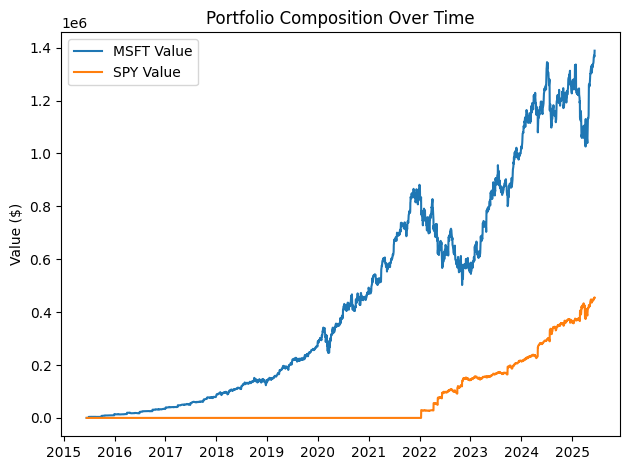

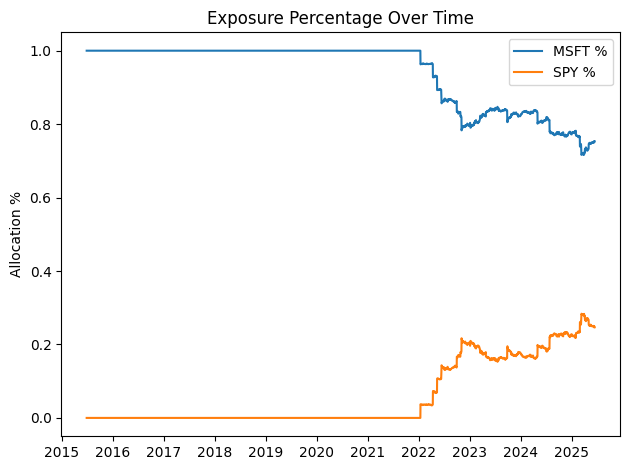

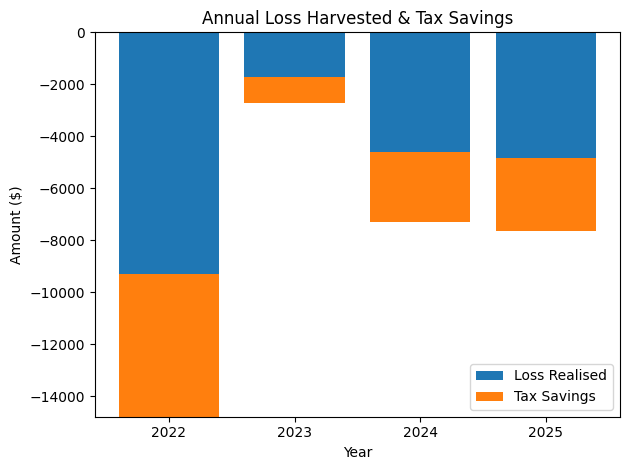

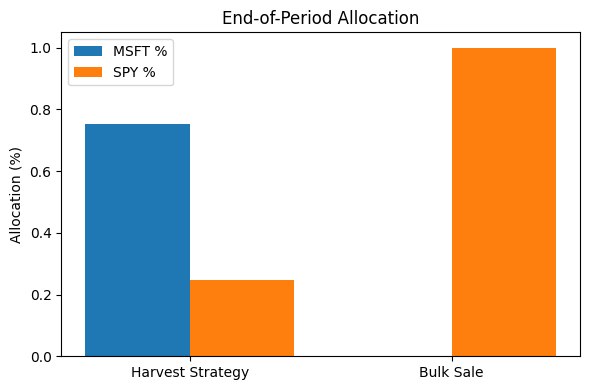

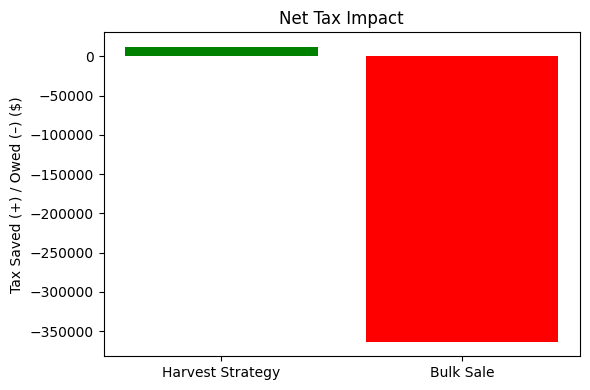

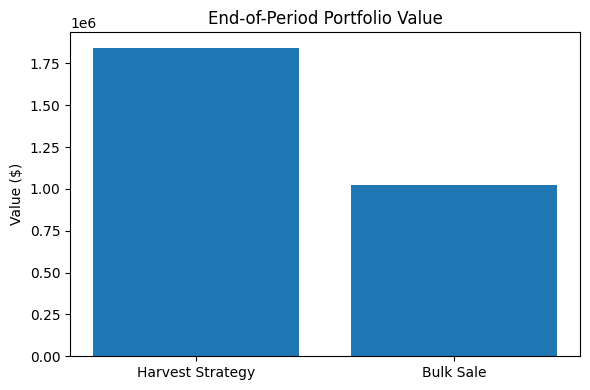

In [ ]:
#!/usr/bin/env python3
"""
####################################################################################################
DIRECT-INDEXING TAX-LOSS-HARVEST SIMULATOR
Author   : Viktor Mashalov

PROFESSIONAL DISCLAIMER  –  NOT FINANCIAL ADVICE
----------------------------------------------------------------------------------------------------
This script is provided strictly for educational and illustrative purposes.  Nothing herein
constitutes or should be construed as personalized investment advice, a solicitation, or a
recommendation to buy, sell, or hold any security or implement any strategy.  Past performance is
not indicative of future results.  Use entirely at your own risk.  Consult your own qualified
financial, tax, and legal advisers before acting on any information contained in or generated by
this program.  The author and all affiliated parties expressly disclaim any liability for losses,
damages, or costs of any kind arising out of the use of this material.
####################################################################################################
"""

# ----------------------------------------- IMPORTS ------------------------------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------- INTERACTIVE USER PARAMETERS -------------------------------------
# You can simply press <Enter> at any prompt to accept the default shown in [brackets].

ticker_rsu = input("RSU ticker symbol [MSFT]                : ").strip().upper() or "MSFT"
start_date = input("Simulation start date  YYYY-MM-DD [2015-06-13] : ").strip() or "2015-06-13"
end_date   = input("Simulation end date    YYYY-MM-DD [2025-06-13] : ").strip() or "2025-06-13"

transition_start_date = (
    input("Loss-harvest & conversion begin date [2021-01-01]: ").strip()
    or "2021-01-01"
)

# --------------------------- STATIC PARAMETERS (EDIT IF DESIRED) ---------------------------------
benchmark_etf        = "SPY"      # ETF into which RSU proceeds are rolled
vest_freq            = "QE-DEC"   # Quarterly vest schedule (Mar/Jun/Sep/Dec)
shares_per_vest      = 100        # Shares that vest each quarter
harvest_loss_pct     = 0.08       # Trigger: % below basis to harvest
assumed_tax_rate     = 0.37       # Marginal tax bracket for savings estimate

# ------------------------------- FETCH PRICE DATA -------------------------------------------------
print(f"\nDownloading price history for {ticker_rsu} and {benchmark_etf} …")
price_rsu = yf.download(ticker_rsu, start=start_date, end=end_date, progress=False)["Close"]
price_etf = yf.download(benchmark_etf, start=start_date, end=end_date, progress=False)["Close"]

# Combine & clean
df = pd.concat([price_rsu, price_etf], axis=1).dropna()
df.columns = ["rsu", "etf"]

# ----------------------------- BUILD VESTING CALENDAR --------------------------------------------
vest_anchor = pd.date_range(start=df.index.min(), end=df.index.max(), freq=vest_freq)
vest_dates  = [df.index[pos] for pos in df.index.searchsorted(vest_anchor) if pos < len(df.index)]

# ------------------------------- INITIALISE STATE -------------------------------------------------
transition_start = pd.to_datetime(transition_start_date)

rsu_lots   = []   # open RSU lots
vest_log   = []   # details of each vest event
trade_log  = []   # harvest-sale events
daily_snap = []   # daily portfolio valuation

# ------------------------------------- MAIN LOOP --------------------------------------------------
for today, prices in df.iterrows():
    rsu_px, etf_px = prices["rsu"], prices["etf"]

    # (a) Vesting
    if today in vest_dates:
        rsu_lots.append({"shares": shares_per_vest, "basis": rsu_px})
        vest_log.append({"date": today, "shares": shares_per_vest, "vest_price": rsu_px})

    # (b) Harvesting after transition start
    if today >= transition_start:
        for lot in rsu_lots.copy():
            if rsu_px < lot["basis"] * (1 - harvest_loss_pct):
                shares, basis = lot["shares"], lot["basis"]
                proceeds      = shares * rsu_px
                loss_amount   = shares * (rsu_px - basis)
                tax_savings   = -loss_amount * assumed_tax_rate

                rsu_lots.remove(lot)
                trade_log.append({
                    "date": today,
                    "shares_sold": shares,
                    "basis": basis,
                    "sale_price": rsu_px,
                    "loss": loss_amount,
                    "tax_savings": tax_savings,
                    "etf_shares_bought": proceeds / etf_px
                })

    # (c) Accumulated ETF shares
    total_etf_shares = sum(t["etf_shares_bought"] for t in trade_log)

    # (d) Daily snapshot
    total_rsu_shares = sum(l["shares"] for l in rsu_lots)
    val_rsu          = total_rsu_shares * rsu_px
    val_etf          = total_etf_shares  * etf_px
    total_val        = val_rsu + val_etf

    daily_snap.append({
        "date": today,
        f"{ticker_rsu}_Shares": total_rsu_shares,
        f"{benchmark_etf}_Shares": total_etf_shares,
        f"{ticker_rsu}_Value": val_rsu,
        f"{benchmark_etf}_Value": val_etf,
        "Total_Value": total_val,
        "Cumulative_Loss": sum(t["loss"] for t in trade_log),
        "Estimated_Tax_Savings": sum(t["tax_savings"] for t in trade_log)
    })

# --------------------------- CONVERT LOGS TO DATAFRAMES -------------------------------------------
results_df = pd.DataFrame(daily_snap).set_index("date")
vest_df    = pd.DataFrame(vest_log).assign(year=lambda x: x["date"].dt.year)
trades_df  = pd.DataFrame(trade_log)
if not trades_df.empty:
    trades_df["year"] = trades_df["date"].dt.year

# -------------------------- FINAL SNAPSHOT & COMPARISONS ------------------------------------------
final_date        = results_df.index[-1]
rsu_px_end        = df.loc[final_date, "rsu"]
etf_px_end        = df.loc[final_date, "etf"]
final_rec         = results_df.iloc[-1]

final_rsu_shares  = final_rec[f"{ticker_rsu}_Shares"]
final_etf_shares  = final_rec[f"{benchmark_etf}_Shares"]
final_port_value  = final_rec["Total_Value"]
tax_savings_strat = final_rec["Estimated_Tax_Savings"]

strat_rsu_pct = (final_rsu_shares * rsu_px_end) / final_port_value
strat_etf_pct = (final_etf_shares * etf_px_end) / final_port_value

# Bulk-sale scenario
remaining_lots      = rsu_lots.copy()
bulk_shares         = sum(l["shares"] for l in remaining_lots)
gross_proceeds_bulk = bulk_shares * rsu_px_end
gain_amount         = sum(l["shares"] * max(0, rsu_px_end - l["basis"]) for l in remaining_lots)
tax_liability_bulk  = gain_amount * assumed_tax_rate
net_proceeds_bulk   = gross_proceeds_bulk - tax_liability_bulk
bulk_etf_shares     = net_proceeds_bulk / etf_px_end
value_etf_bulk      = bulk_etf_shares * etf_px_end

# ------------------------------ PRINT TEXT OUTPUT -------------------------------------------------
pd.set_option("display.float_format", "{:,.2f}".format)

print("\n======================= VESTING LOG =======================")
print(vest_df[["date", "shares", "vest_price"]].to_string(index=False))

print("\n================== VESTED SHARES BY YEAR ==================")
print(vest_df.groupby("year").agg(total_vested_shares=("shares","sum"),
                                  avg_vest_price=("vest_price","mean")).to_string())

if not trades_df.empty:
    print("\n==================== HARVEST TRADES LOG ==================")
    print(trades_df[["date","shares_sold","basis","sale_price",
                     "loss","tax_savings","etf_shares_bought"]].to_string(index=False))

    print("\n================= REALISED LOSS & TAX SAVINGS ============")
    print(trades_df.groupby("year").agg(loss_realised=("loss","sum"),
                                        tax_savings=("tax_savings","sum")).to_string())

print(f"\n================= END-OF-PERIOD (as of {final_date.date()}) ================")
print("Tax-Loss-Harvest Strategy")
print(f"  • Portfolio Value    : ${final_port_value:,.2f}")
print(f"  • {ticker_rsu} Allocation : {strat_rsu_pct:.1%}")
print(f"  • {benchmark_etf} Allocation : {strat_etf_pct:.1%}")
print(f"  • Net Tax Impact     : \033[92m${tax_savings_strat:,.2f} saved\033[0m\n")

print("All-at-Once Bulk Sale")
print(f"  • Gross Proceeds     : ${gross_proceeds_bulk:,.2f}")
print(f"  • Net Tax Impact     : \033[91m${tax_liability_bulk:,.2f} owed\033[0m")
print(f"  • Net Proceeds       : ${net_proceeds_bulk:,.2f}")

# --------------------------------------- PLOTTING -------------------------------------------------
plt.style.use("default")

# (1) Value timeline
fig, ax = plt.subplots()
ax.plot(results_df.index, results_df[f"{ticker_rsu}_Value"], label=f"{ticker_rsu} Value")
ax.plot(results_df.index, results_df[f"{benchmark_etf}_Value"], label=f"{benchmark_etf} Value")
ax.set_title("Portfolio Composition Over Time")
ax.set_ylabel("Value ($)")
ax.legend()
plt.tight_layout()
plt.show()

# (2) Allocation %
fig2, ax2 = plt.subplots()
ax2.plot(results_df.index,
         results_df[f"{ticker_rsu}_Value"] / results_df["Total_Value"],
         label=f"{ticker_rsu} %")
ax2.plot(results_df.index,
         results_df[f"{benchmark_etf}_Value"] / results_df["Total_Value"],
         label=f"{benchmark_etf} %")
ax2.set_title("Exposure Percentage Over Time")
ax2.set_ylabel("Allocation %")
ax2.legend()
plt.tight_layout()
plt.show()

# (3) Annual realised loss & tax savings
if not trades_df.empty:
    yearly = trades_df.groupby("year").agg(loss=("loss","sum"), tax=("tax_savings","sum"))
    fig3, ax3 = plt.subplots()
    ax3.bar(yearly.index.astype(str), yearly["loss"], label="Loss Realised")
    ax3.bar(yearly.index.astype(str), yearly["tax"], bottom=yearly["loss"],
            label="Tax Savings")
    ax3.set_title("Annual Loss Harvested & Tax Savings")
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Amount ($)")
    ax3.legend()
    plt.tight_layout()
    plt.show()

# (4) Allocation comparison
fig4, ax4 = plt.subplots(figsize=(6,4))
x, width = np.arange(2), 0.4
ax4.bar(x - width/2, [strat_rsu_pct, 0],     width, label=f"{ticker_rsu} %")
ax4.bar(x + width/2, [strat_etf_pct, 1.0],   width, label=f"{benchmark_etf} %")
ax4.set_xticks(x)
ax4.set_xticklabels(["Harvest Strategy", "Bulk Sale"])
ax4.set_title("End-of-Period Allocation")
ax4.set_ylabel("Allocation (%)")
ax4.legend()
plt.tight_layout()
plt.show()

# (5) Net tax comparison
fig5, ax5 = plt.subplots(figsize=(6,4))
labels = ["Harvest Strategy", "Bulk Sale"]
impact = [tax_savings_strat, -tax_liability_bulk]
ax5.bar(labels, impact, color=["green" if v>=0 else "red" for v in impact])
ax5.set_title("Net Tax Impact")
ax5.set_ylabel("Tax Saved (+) / Owed (–) ($)")
plt.tight_layout()
plt.show()

# (6) Portfolio value comparison
fig6, ax6 = plt.subplots(figsize=(6,4))
ax6.bar(["Harvest Strategy","Bulk Sale"],
        [final_port_value, value_etf_bulk])
ax6.set_title("End-of-Period Portfolio Value")
ax6.set_ylabel("Value ($)")
plt.tight_layout()
plt.show()